In [1]:
import numpy as np
from lanczos import *
from timeIntegration import *
from plotting import *
from utils import *

## Exercise 4)

In [2]:
# epss = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
epss = [1e-1, 1e-5]
ks = [10, 20]
TOL = 1e-2
resultsByKByEps = {}
for k in ks:
    resultsByKByEps[k] = GetTimeIntegrationResults(epss=epss, k=k, verbose=0)


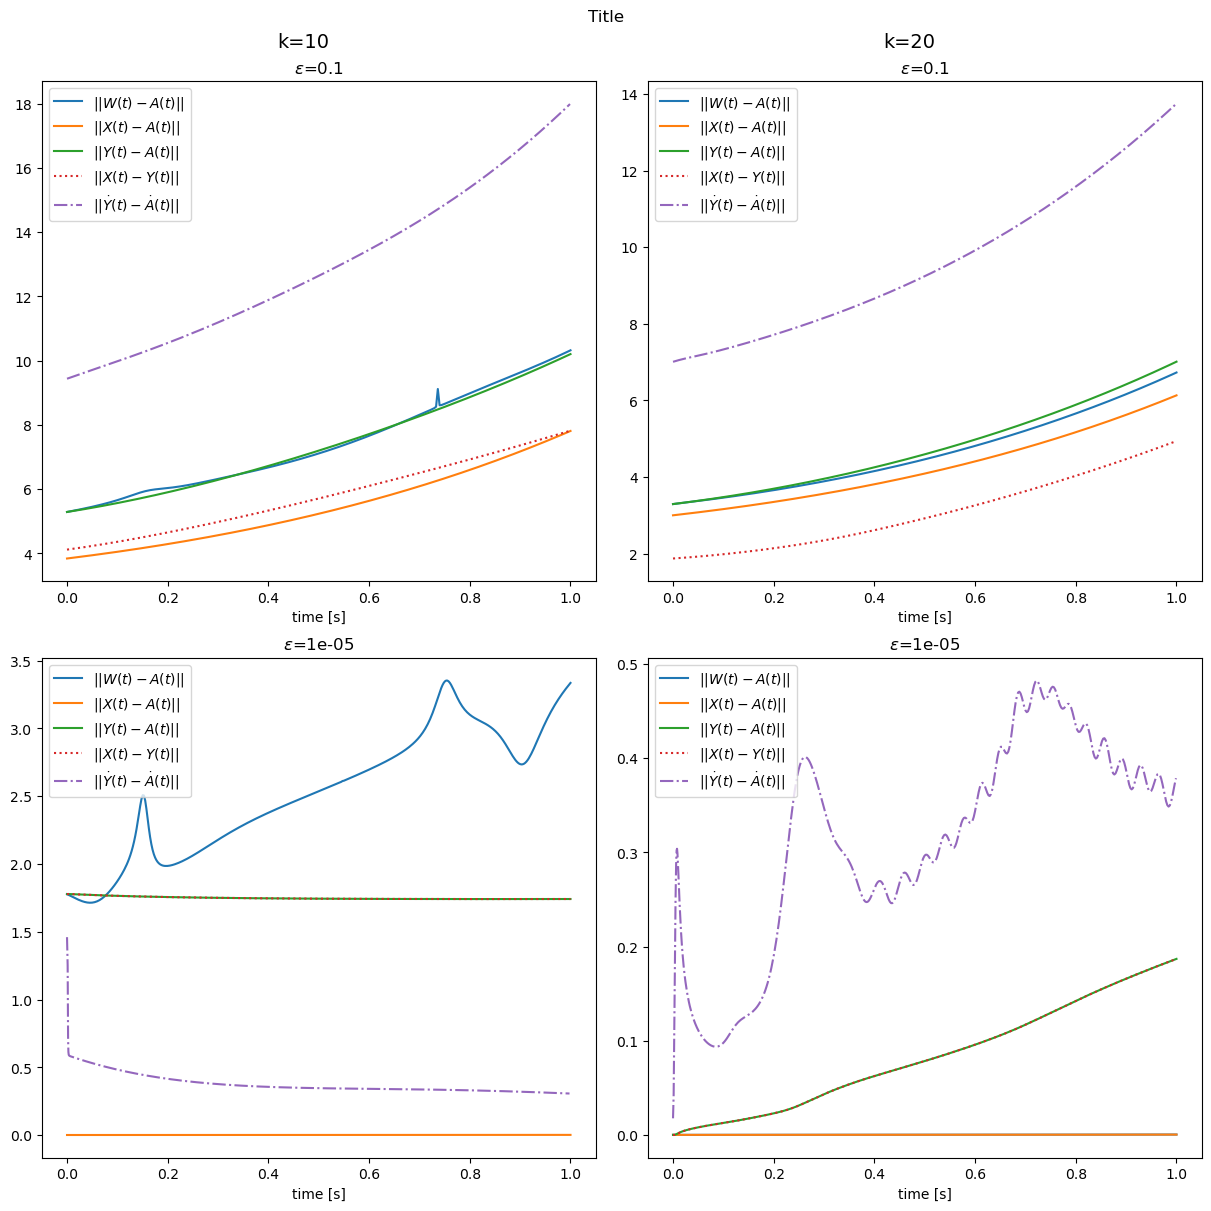

In [3]:
ksToPlot = 2
epssToPlot = len(epss)
res = 6
fig = plt.figure(constrained_layout=True, figsize=(ksToPlot*res, epssToPlot*res))
fig.suptitle(f"Title")
subfigs = fig.subfigures(nrows=1, ncols=ksToPlot)
for row, subfig in enumerate(subfigs):
    k = ks[row]
    subfig.suptitle(f"k={k}", fontsize=14)
    axs = subfig.subplots(nrows=epssToPlot, ncols=1)
    for col, ax in enumerate(axs):
        eps = epss[col]
        plotTimeIntegrationResults(ax, resultsByKByEps[k][eps], f"$\epsilon$={eps}")
# plt.tight_layout()
plt.show()

In [4]:
tables = makeTables(resultsByKByEps)
# Displaying the tables in a nice format in the notebook
from IPython.display import display, HTML

# Loop through the tables dictionary to display each table with a title
for k, df_k in tables.items():
    display(HTML(f"<h3>Table for k={k}</h3>"))
    display(df_k)

,epsilon,$||W(t)-A(t)||$,$||X(t)-A(t)||$,$||Y(t)-A(t)||$,$||X(t)-Y(t)||$,$||\dot{Y}(t)-\dot{A}(t)||$
1,0.00001,3.335118,0.001837,1.741398,1.741397,0.306931
0,0.10000,10.324541,7.813547,10.206705,7.822860,17.991155


,epsilon,$||W(t)-A(t)||$,$||X(t)-A(t)||$,$||Y(t)-A(t)||$,$||X(t)-Y(t)||$,$||\dot{Y}(t)-\dot{A}(t)||$
1,0.00001,0.000672,0.000615,0.18706,0.187060,0.378758
0,0.10000,6.729187,6.132426,7.01172,4.939552,13.736092
